**Imports**

In [1]:
import os
import glob
import numpy as np
import SimpleITK as sitk
import matplotlib.pyplot as plt
from IPython.display import display, clear_output
from monai.transforms import (
    Compose, LoadImageD, EnsureChannelFirstD, ScaleIntensityRangeD, RandRotateD,
    RandFlipD, ToTensorD
)
from monai.data import Dataset, DataLoader, CacheDataset
import monai
from PIL import Image
import nibabel as nib
import pandas as pd
import torch
from matplotlib.colors import ListedColormap
from tqdm import tqdm
import cv2
from monai.transforms import Transform

#!pip install nibabel

num_classes = 4
class_names = ['background', 'RV', 'MY', 'LV']

C:\Users\gijsd\anaconda3\Lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated and will be removed in a future release
  "class": algorithms.Blowfish,


**Data Collection**

First we collect all the filepaths.

In [2]:
testing_path = '../data/testing/'
training_path = '../data/training/'

def get_acdc_file_paths(data_path):
    original_images = glob.glob(os.path.join(data_path, 'patient*/patient*_frame??.nii.gz'))
    gt_images = glob.glob(os.path.join(data_path, 'patient*/patient*_frame??_gt.nii.gz'))

    return original_images, gt_images

training_original_images, training_gt_images = get_acdc_file_paths(training_path)
testing_original_images, testing_gt_images = get_acdc_file_paths(testing_path)

print("Training Original Images:", len(training_original_images))
print("Training GT Images:", len(training_gt_images))
print("Testing Original Images:", len(testing_original_images))
print("Testing GT Images:", len(testing_gt_images))

Training Original Images: 200
Training GT Images: 200
Testing Original Images: 100
Testing GT Images: 100


Then we create a dataframe to store all metadata

In [3]:
# Create a dataframe to store the patient number, frame number, the file path of the image, gt file path and whether it is a training or testing image

def parse_info_file(info_file_path):
    info_dict = {}
    with open(info_file_path, 'r') as file:
        for line in file:
            key, value = line.strip().split(': ')
            info_dict[key] = value if key == 'Group' else float(value) if '.' in value else int(value)
    return info_dict

def get_acdc_file_paths(data_paths):
    data_records = []
    
    for data_path, dataset_type in data_paths:
        # Get all the image and ground truth file paths
        image_pattern = os.path.join(data_path, 'patient*/patient*_frame??.nii.gz')
        gt_pattern = os.path.join(data_path, 'patient*/patient*_frame??_gt.nii.gz')
        image_paths = glob.glob(image_pattern)
        gt_paths = glob.glob(gt_pattern)

        # Convert gt_paths to a dictionary for quick lookup
        gt_dict = {os.path.basename(gt_path).replace('_gt', ''): gt_path for gt_path in gt_paths}

        for image_path in image_paths:
            basename = os.path.basename(image_path)
            patient_number = basename.split('_')[0].replace('patient', '')
            frame_number = basename.split('_')[1].replace('frame', '').replace('.nii.gz', '')

            # Extracting the directory path to read the info.cfg
            patient_dir = os.path.dirname(image_path)
            info_file_path = os.path.join(patient_dir, 'info.cfg')
            patient_info = parse_info_file(info_file_path)

            gt_path = gt_dict.get(basename, None)

            data_records.append({
                'patient_number': patient_number,
                'frame_number': frame_number,
                'image_path': image_path,
                'gt_path': gt_path,
                'dataset_type': dataset_type,
                **patient_info  # Add the info.cfg data to the record
            })

    # Create a DataFrame
    df = pd.DataFrame(data_records)

    return df

training_path = '../data/Training'
testing_path = '../data/Testing'

# Call the function with both paths and their dataset types
data_paths = [(training_path, 'Training'), (testing_path, 'Testing')]
df_metadata = get_acdc_file_paths(data_paths)

# Count the number of entries of each dataset type
counts = df_metadata['dataset_type'].value_counts()
print(counts)


dataset_type
Training    200
Testing     100
Name: count, dtype: int64


In [4]:
df_metadata.head(10)

,patient_number,frame_number,image_path,gt_path,dataset_type,ED,ES,Group,Height,NbFrame,Weight
0,001,01,../data/Training\patient001\patient001_frame01...,../data/Training\patient001\patient001_frame01...,Training,1,12,DCM,184.0,30,95.0
1,001,12,../data/Training\patient001\patient001_frame12...,../data/Training\patient001\patient001_frame12...,Training,1,12,DCM,184.0,30,95.0
2,002,01,../data/Training\patient002\patient002_frame01...,../data/Training\patient002\patient002_frame01...,Training,1,12,DCM,160.0,30,70.0
3,002,12,../data/Training\patient002\patient002_frame12...,../data/Training\patient002\patient002_frame12...,Training,1,12,DCM,160.0,30,70.0
4,003,01,../data/Training\patient003\patient003_frame01...,../data/Training\patient003\patient003_frame01...,Training,1,15,DCM,165.0,30,77.0
5,003,15,../data/Training\patient003\patient003_frame15...,../data/Training\patient003\patient003_frame15...,Training,1,15,DCM,165.0,30,77.0
6,004,01,../data/Training\patient004\patient004_frame01...,../data/Training\patient004\patient004_frame01...,Training,1,15,DCM,159.0,28,46.0
7,004,15,../data/Training\patient004\patient004_frame15...,../data/Training\patient004\patient004_frame15...,Training,1,15,DCM,159.0,28,46.0
8,005,01,../data/Training\patient005\patient005_frame01...,../data/Training\patient005\patient005_frame01...,Training,1,13,DCM,165.0,30,77.0
9,005,13,../data/Training\patient005\patient005_frame13...,../data/Training\patient005\patient005_frame13...,Training,1,13,DCM,165.0,30,77.0


In [5]:
# Split the DataFrame into training and testing sets
train_df = df_metadata[df_metadata['dataset_type'] == 'Training']
test_df = df_metadata[df_metadata['dataset_type'] == 'Testing']

# Split the testing set into ES and ED stages
test_ed_df = test_df[test_df['frame_number'].astype(int) == test_df['ED']]
test_es_df = test_df[test_df['frame_number'].astype(int) == test_df['ES']]

In [6]:
import torch.nn.functional as F

def one_hot_encode(slice_label, num_classes):
    slice_label = torch.tensor(slice_label, dtype=torch.long)
    one_hot_label = F.one_hot(slice_label, num_classes=num_classes).permute(2, 0, 1)
    return one_hot_label.numpy()

# Convert 3D images to 2D slices
def create_slices_dict(df, num_classes=4):
    slices_dict = []
    for _, row in df.iterrows():
        image_data = nib.load(row['image_path'])
        label_data = nib.load(row['gt_path'])
        
        image = image_data.get_fdata()
        label = label_data.get_fdata()
        
        for i in range(image.shape[-1]):  # Iterate over the slices
            slice_image = image[:, :, i].astype(np.float32)
            slice_image = np.expand_dims(slice_image, axis=0) # from (W, H) to (1, W, H)
            
            slice_label = label[:, :, i].astype(np.float32)       # Classes are 0, 1, 2, 3
            slice_label = np.expand_dims(slice_label, axis=0) # from (W, H) to (1, W, H)
            #slice_label = one_hot_encode(slice_label, num_classes)
            
            pixel_spacing = image_data.header['pixdim'][1:3]
            slice_affine = image_data.affine[:2, :2]
            slice_affine = np.pad(slice_affine, ((0, 1), (0, 1)), mode='constant')
            slice_affine[-1, -1] = 1
            
            meta_dict = {
                'affine': slice_affine,
                'spatial_shape': slice_image.shape,
                'original_channel_dim': 0,
                'slice_number': i,
                'pixdim': pixel_spacing
            }
            
            # Add DataFrame row information to the metadata
            for col in df.columns:
                meta_dict[col] = row[col]

            slices_dict.append({'image': slice_image, 'label': slice_label, 'image_meta_dict': meta_dict, 'mask_meta_dict': meta_dict})
    return slices_dict

training_slices_dict = create_slices_dict(train_df)
testing_slices_dict = create_slices_dict(test_df)

testing_ed_slices_dict = create_slices_dict(test_ed_df)
testing_es_slices_dict = create_slices_dict(test_es_df)

# Define custom transform to load data
# class LoadData(Transform):
#     def __init__(self, keys=None):
#         pass
# 
#     def __call__(self, sample):
#         image = sample['image']
#         mask = sample['label']
# 
#         return {'image': image, 'label': mask, 'image_meta_dict': sample['image_meta_dict'], 'mask_meta_dict': sample['mask_meta_dict']}
from monai.data import MetaTensor

class LoadData(Transform):
    def __init__(self, keys=None):
        pass

    def __call__(self, sample):
        image = sample['image']
        mask = sample['label']

        image_meta_dict = sample['image_meta_dict']
        mask_meta_dict = sample['mask_meta_dict']

        # Convert image and mask to MetaTensor with associated metadata
        image = MetaTensor(image, affine=image_meta_dict['affine'])
        mask = MetaTensor(mask, affine=mask_meta_dict['affine'])

        return {'image': image, 'label': mask, 'image_meta_dict': image_meta_dict, 'mask_meta_dict': mask_meta_dict}

**Investigate distribution of intensity values and apply histogram equalization**

Computing histogram: 100%|██████████| 200/200 [00:02<00:00, 78.84it/s]


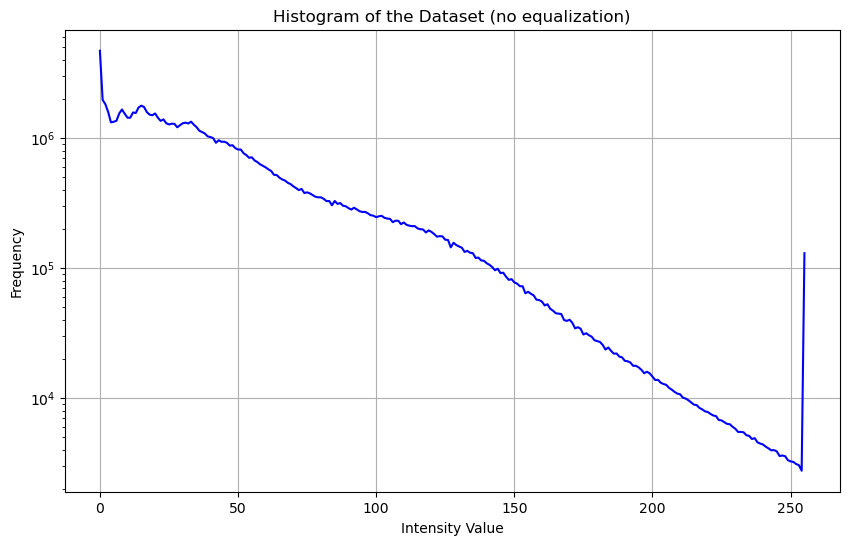

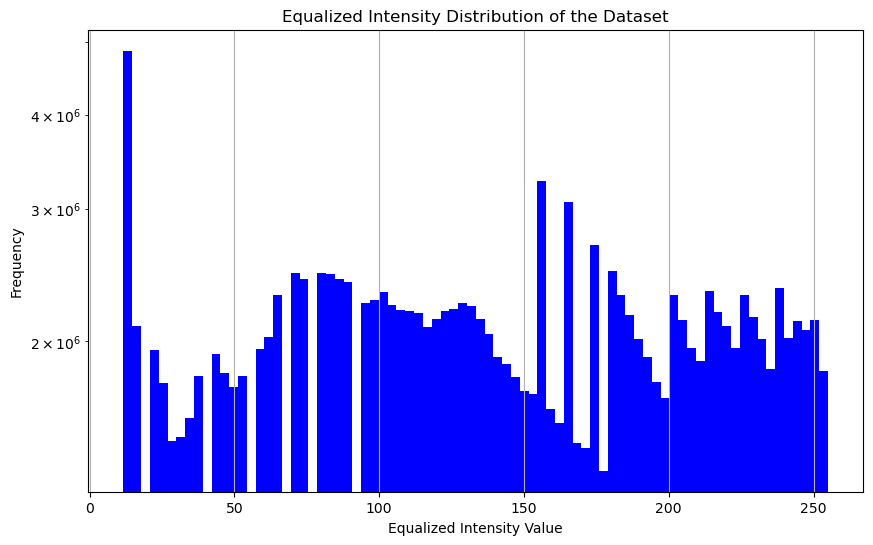

In [7]:
def compute_histogram_and_cdf(df):
    hist = np.zeros(256)

    for image_path in tqdm(df['image_path'], desc="Computing histogram"):
        image = nib.load(image_path).get_fdata()
        image = (image / np.max(image) * 255).astype(np.uint8)  # Normalize to [0, 255]
        hist += np.histogram(image, bins=256, range=(0, 256))[0]

    cdf = hist.cumsum()
    cdf_normalized = cdf * (255 / cdf[-1])  # Normalize CDF to [0, 255]

    return hist, cdf_normalized

# Function to apply histogram equalization using the CDF
def apply_histogram_equalization(image, cdf):
    image = (image / np.max(image) * 255).astype(np.uint8)  # Normalize to [0, 255]
    equalized_image = cdf[image]
    return equalized_image

# Apply histogram equalization to all images and collect intensity values for visualization
def collect_equalized_intensity_values(df, cdf):
    intensity_values = []

    for image_path in tqdm(df['image_path'], desc="Collecting equalized values"):
        image = nib.load(image_path).get_fdata()
        equalized_image = apply_histogram_equalization(image, cdf)
        intensity_values.extend(equalized_image.flatten())

    return np.array(intensity_values)

# Compute the histogram and CDF of the entire training dataset
hist, cdf = compute_histogram_and_cdf(df_metadata[df_metadata['dataset_type'] == 'Training']) # Note, we only use the training dataset because we don't want to leak information from the testing dataset

# Show the histogram, before equalization
plt.figure(figsize=(10, 6))
plt.plot(hist, color='blue')
plt.title('Histogram of the Dataset (no equalization)')
plt.xlabel('Intensity Value')
plt.ylabel('Frequency')
plt.yscale('log')
plt.grid(True)
plt.show()

# Collect equalized intensity values from the DataFrame
equalized_intensity_values = collect_equalized_intensity_values(df_metadata, cdf)


# Plot the histogram of equalized intensity values
plt.figure(figsize=(10, 6))
plt.hist(equalized_intensity_values, bins=80, color='blue')
plt.title('Equalized Intensity Distribution of the Dataset')
plt.xlabel('Equalized Intensity Value')
plt.ylabel('Frequency')
plt.yscale('log')
plt.grid(True)
plt.show()


In [8]:
from skimage import exposure

class HistogramEqualization(Transform):
    def __call__(self, sample):
        image = sample['image']

        if isinstance(image, MetaTensor):
            image_data = image.as_tensor()
            image_meta_dict = image.meta
            equalized_image = exposure.equalize_hist(image_data.numpy())  # Normalizes to [0, 1]
            equalized_image = MetaTensor(equalized_image * 255, meta=image_meta_dict)
        else:
            equalized_image = exposure.equalize_hist(image)
            equalized_image = equalized_image * 255 
        sample['image'] = equalized_image
        return sample

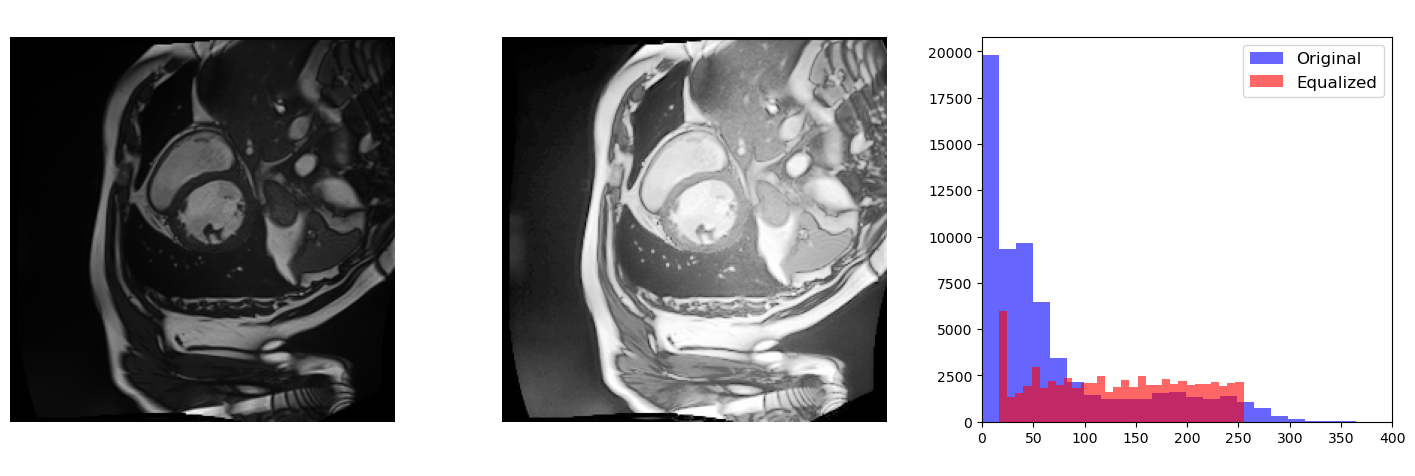

In [9]:
interest_idx = 42

# Test the transformation on a single image and visualize it
sample_image = training_slices_dict[interest_idx]['image']
sample_image = sample_image.squeeze()
#sample_image = sample_image[0]
sample_image = np.expand_dims(sample_image, axis=0)

transform_test = HistogramEqualization()
transformed_data = transform_test({'image': sample_image, 'image_meta_dict': training_slices_dict[interest_idx]['image_meta_dict']})
equalized_sample_image = transformed_data['image'].squeeze()

sample_image = sample_image.squeeze()

# Display the original and equalized images along with their histograms
plt.figure(figsize=(18, 5))

# Original Image
plt.subplot(1, 3, 1)
plt.imshow(sample_image, cmap='gray')
plt.title('Original Image', fontsize=18, color='white')
plt.axis('off')

# Equalized Image
plt.subplot(1, 3, 2)
plt.imshow(equalized_sample_image, cmap='gray')
plt.title('Histogram Equalized Image', fontsize=18, color='white')
plt.axis('off')

# Histogram of Intensity Values
n_bins = 30
plt.subplot(1, 3, 3)
plt.hist(sample_image.ravel(), bins=n_bins, color='blue', alpha=0.6, label='Original')
plt.hist(equalized_sample_image.ravel(), bins=n_bins, color='red', alpha=0.6, label='Equalized')
plt.legend(loc='upper right', fontsize=12)
plt.title('Histogram of Intensity Values', fontsize=18, color='white')
plt.xlabel('Intensity Value', fontsize=12, color='white')
plt.ylabel('Count', fontsize=12, color='white')
plt.xlim([0, 400])
# save img as png
plt.savefig('histogram_equalization_demonstration.png', dpi=300, bbox_inches='tight', transparent=True)
# save img without background

plt.show()

Before:  317.1875 350.0
AFter 232.70000000000002 256.1
pixdim after [[-1. -0.  0.]
 [-0. -1.  0.]
 [ 0.  0.  1.]]


C:\Users\gijsd\anaconda3\Lib\site-packages\monai\transforms\spatial\array.py:494: UserWarning: `data_array` is not of type MetaTensor, assuming affine to be identity.
  warnings.warn("`data_array` is not of type MetaTensor, assuming affine to be identity.")


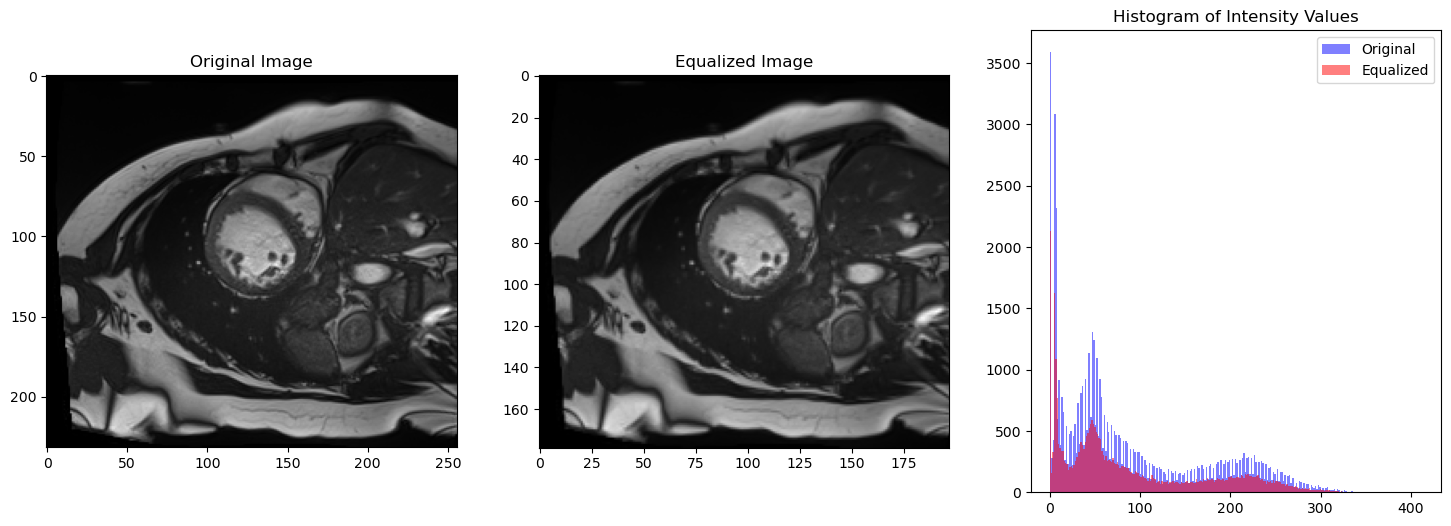

In [10]:
# Test the transformation on a single image and visualize it
sample_image = training_slices_dict[22]['image']
sample_image = sample_image.squeeze()
#sample_image = sample_image[0]
sample_image = np.expand_dims(sample_image, axis=0)

voxel_spacing_before = training_slices_dict[22]['image_meta_dict']['pixdim']
#total size before
print("Before: ", sample_image.shape[1]*voxel_spacing_before[0], sample_image.shape[2]*voxel_spacing_before[1])

new_spacing = (1.3,1.3)
#transform_test = HistogramEqualization()
transform_test = monai.transforms.SpacingD(keys=['image'], pixdim=new_spacing, mode='bilinear')
transformed_data = transform_test({'image': sample_image, 'image_meta_dict': training_slices_dict[22]['image_meta_dict']})
equalized_sample_image = transformed_data['image'].squeeze()

#print total size after
print("AFter", equalized_sample_image.shape[0]*new_spacing[0], equalized_sample_image.shape[1]*new_spacing[1])
print("pixdim after", transformed_data['image_meta_dict']['affine'])

sample_image = sample_image.squeeze()

# Display the original and equalized images along with their histograms
plt.figure(figsize=(18, 6))

# Original Image
plt.subplot(1, 3, 1)
plt.imshow(sample_image, cmap='gray')
plt.title('Original Image')

# Equalized Image
plt.subplot(1, 3, 2)
plt.imshow(equalized_sample_image, cmap='gray')
plt.title('Equalized Image')

# Histogram of Intensity Values
plt.subplot(1, 3, 3)
plt.hist(sample_image.ravel(), bins=256, color='blue', alpha=0.5, label='Original')
plt.hist(equalized_sample_image.ravel(), bins=256, color='red', alpha=0.5, label='Equalized')
plt.legend(loc='upper right')
plt.title('Histogram of Intensity Values')

plt.show()

In [11]:
# Patch size, should be divisible by 2 repeatedly for UNet
size_y = 256
size_x = 256
pixdim_x = 0.9
pixdim_y = 0.9
# TODO: probably change which transforms to take

class ConvertToFloat32:
    def __call__(self, sample):
        sample['image'] = sample['image'].astype(np.float32)
        sample['label'] = sample['label'].astype(np.float32)
        return sample

train_transform = monai.transforms.Compose([ #composed of several transforms
    LoadData(keys=['image', 'label']),
    HistogramEqualization(),
    monai.transforms.ScaleIntensityd(keys=['image'], minv=0.0, maxv=1.0),
    monai.transforms.SpacingD(keys=['image', 'label'], pixdim=(pixdim_x, pixdim_y, None), mode=['bilinear', 'nearest']),
    monai.transforms.RandRotateD(keys=['image', 'label'], range_x=0.18, prob=0.5, mode=['bilinear', 'nearest'], keep_size=False, padding_mode='zeros'), # Rotate up to 360 degrees
    monai.transforms.RandFlipD(keys=['image', 'label'], spatial_axis=0, prob=0.25), # Flip along x-axis
    monai.transforms.RandFlipD(keys=['image', 'label'], spatial_axis=1, prob=0.25), # Flip along y-axis
    monai.transforms.ResizeWithPadOrCropd(keys=['image', 'label'], spatial_size=[size_x+30, size_y+30]),
    monai.transforms.RandSpatialCropd(keys=['image', 'label'], roi_size=[size_x, size_y], random_size=False), # Crop patch
    monai.transforms.ToTensorD(keys=['image', 'label'])
])

val_transform = monai.transforms.Compose([
    LoadData(keys=['image', 'label']),
    HistogramEqualization(),
    monai.transforms.ScaleIntensityd(keys=['image'], minv=0.0, maxv=1.0),
    monai.transforms.SpacingD(keys=['image', 'label'], pixdim=(pixdim_x, pixdim_y, None), mode=['bilinear', 'nearest']),
    ConvertToFloat32(),
    monai.transforms.ResizeWithPadOrCropd(keys=['image', 'label'], spatial_size=[size_x+30, size_y+30]),
    monai.transforms.RandSpatialCropd(keys=['image', 'label'], roi_size=[size_x, size_y], random_size=False),
    monai.transforms.ToTensorD(keys=['image', 'label'])
])

train_dataset = Dataset(data=training_slices_dict, transform=train_transform) #TODO: split into validation and training set...
test_dataset = Dataset(data=testing_slices_dict, transform=val_transform)

batch_size = 8
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

Image shape:  torch.Size([1, 256, 256])


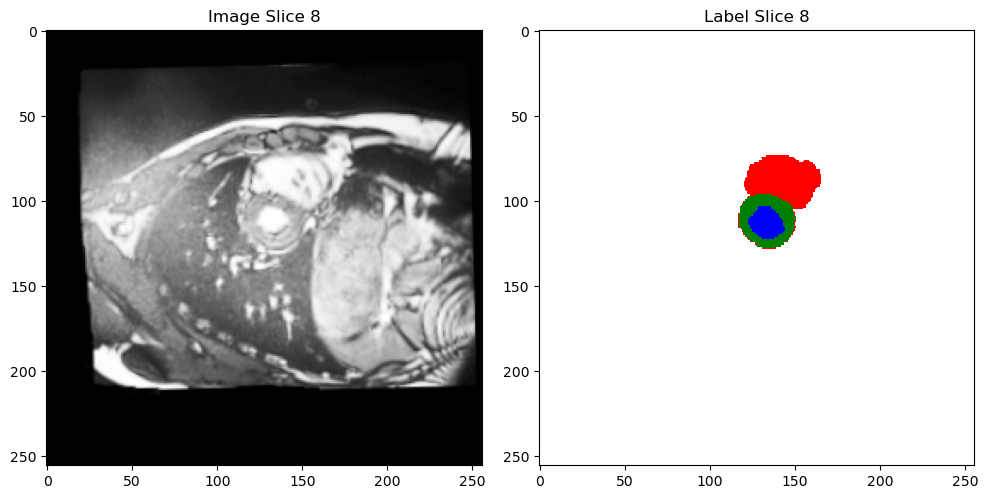

In [12]:
label_cmap = ListedColormap(['none', 'red', 'green', 'blue'])

def visualize_single_sample(data_loader):
    data_batch = next(iter(data_loader))
    batch_index = 0
    image, label = data_batch['image'][batch_index], data_batch['label'][batch_index]
    slice_number = data_batch['image_meta_dict']['slice_number'][batch_index]
        
    #PRINT PIXEL SPACING
    #print(data_batch['image'].meta)
    #print shape
    print("Image shape: ", image.shape)
    
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    axes[0].imshow(image[0].numpy(), cmap="gray")
    axes[0].set_title(f"Image Slice {slice_number}")
    axes[1].imshow(label[0].numpy(), cmap=label_cmap)
    axes[1].set_title(f"Label Slice {slice_number}")
    plt.tight_layout()
    plt.show()

# Visualize a single sample from the training loader
visualize_single_sample(train_loader)

Setting up the UNet model

In [13]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'The used device is {device}')

The used device is cuda


In [14]:
# Fifth run:
model = monai.networks.nets.UNet( #default kernel size is 3
    spatial_dims=2,
    in_channels=1,
    out_channels=4,
    channels=(16, 32, 64, 128),
    strides=(2, 2, 2),
    num_res_units=2,
    kernel_size=5,  
    up_kernel_size=5,
    dropout=0.2
).to(device)

#model.load_state_dict(torch.load('../model_saves/trainedUNet_Fifth_Run_checkpoint_55.pt'))


#Sixth run:
# model = monai.networks.nets.UNet( #default kernel size is 3
#     spatial_dims=2,
#     in_channels=1,
#     out_channels=4,
#     channels=(16, 32, 64, 128, 256),
#     strides=(2, 2, 2, 2),
#     num_res_units=2,
#     kernel_size=5,
#     up_kernel_size=5,
#     dropout=0.2
# ).to(device)

#Seventh run:
# model = monai.networks.nets.SwinUNETR(
#     img_size=(size_x, size_y),  
#     in_channels=1,
#     out_channels=4,
#     feature_size=48,  
#     spatial_dims=2,
#     use_checkpoint=True,  # Set to True to enable gradient checkpointing for memory savings
#     #use_v2=True,  # Set to True to use Swin Transformer v2
# ).to(device)
#TODO: possibly needs more parameters... 
#TODO: can play around with parameters here, especially feature size, dropout, use_v2 (not sure if it can work)

#model.load_state_dict(torch.load('../model_saves/trainedUNet_Seventh_Run_checkpoint_55.pt'))


<All keys matched successfully>

In [15]:
import wandb

wandb.login()

wandb: Currently logged in as: gijsdesmit (gijsds). Use `wandb login --relogin` to force relogin


True

In [16]:
def from_compose_to_list(compose_obj):
    return [str(transform) for transform in compose_obj.transforms]

run_name = 'Fifth_Run'
run = wandb.init(project='Project - UNet',
                 name=run_name, 
                 config={'dataset': 'ACDC',
                         'model': 'SwinUNETR',
                         'loss function': 'DiceLoss',
                         'optimizer': 'Adam',
                         'transform': from_compose_to_list(train_transform),
                         'batch size': batch_size})

run_id = run.id

In [17]:
def wandb_masks(mask_output, mask_gt):
    """ Function that generates a mask dictionary in format that W&B requires """

    # Transform masks to numpy arrays on CPU
    mask_output = mask_output.squeeze().detach().cpu().numpy()
    mask_gt = mask_gt.squeeze().detach().cpu().numpy()

    # Create mask dictionary with class labels and insert masks
    class_labels = {0: 'background', 1: 'RV', 2: 'MY', 3: 'LV'}
    masks = {
        'predictions': {'mask_data': mask_output, 'class_labels': class_labels},
        'ground truth': {'mask_data': mask_gt, 'class_labels': class_labels}
    }
    return masks

def log_to_wandb(epoch, train_loss, val_loss, batch_data, outputs):
    """ Function that logs ongoing training variables to W&B """

    # Apply softmax and argmax to the model output
    softmax = torch.nn.Softmax(dim=1)
    outputs = softmax(outputs)
    outputs = torch.argmax(outputs, dim=1)  # Change to dim=1 for batch processing

    # Create list of images that have segmentation masks for model output and ground truth
    log_imgs = [
        wandb.Image(
            img.cpu().numpy().transpose(1, 2, 0),  # Ensure images are in (H, W, C) format
            masks=wandb_masks(mask_output, mask_gt)
        )
        for img, mask_output, mask_gt in zip(batch_data['image'], outputs, batch_data['label'])
    ]

    # Send epoch, losses and images to W&B
    wandb.log({'epoch': epoch, 'train_loss': train_loss, 'val_loss': val_loss, 'results': log_imgs})


**Training the model**

In [18]:
#loss_function =  monai.losses.DiceLoss(sigmoid=True, batch=True)
import torch.nn as nn

# class CombinedLoss(nn.Module):
#     def __init__(self, dice_weight=0.5):
#         super(CombinedLoss, self).__init__()
#         self.dice_weight = dice_weight
#         self.dice_loss = monai.losses.DiceLoss(to_onehot_y=True, softmax=True)
#         self.ce_loss = nn.CrossEntropyLoss()
# 
#     def forward(self, outputs, targets):
#         dice_loss = self.dice_loss(outputs, targets)
#         ce_loss = self.ce_loss(outputs, torch.argmax(targets, dim=1))
#         return self.dice_weight * dice_loss + (1 - self.dice_weight) * ce_loss
# 
# # Usage
# loss_function = CombinedLoss(dice_weight=0.5)

# loss_function =  monai.losses.DiceLoss(sigmoid=True, batch=True)
loss_function = monai.losses.DiceLoss(to_onehot_y=True, softmax=True)#, weight=[0.1, 0.3, 0.3, 0.3]
#TODO: potentially change this, look for different loss metrics, include weight?

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

#TODO: potentially load model from checkpoint to continue training

In [19]:
start_epoch = 0
n_epochs = 100

for epoch in tqdm(range(start_epoch, n_epochs), desc="Training progress in epochs"):
    model.train()
    train_loss = 0
    for batch_data in train_loader:
        inputs = batch_data['image'].to(device)
        masks = batch_data['label'].to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_function(outputs, masks)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    train_loss /= len(train_loader)

    # Validation
    model.eval()
    val_loss = 0
    for batch_data in val_loader:
        inputs = batch_data['image'].to(device)
        masks = batch_data['label'].to(device)
        outputs = model(inputs)
        loss = loss_function(outputs, masks)
        val_loss += loss.item()        
       
    val_loss /= len(val_loader)
    
    log_to_wandb(epoch, train_loss, val_loss, batch_data, outputs)
    print(f"Epoch {epoch+1}/{n_epochs}, Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}")
    
    if epoch % 5 == 0:
        torch.save(model.state_dict(), '../model_saves/trainedUNet_' + run_name + '_checkpoint_' + str(epoch) + '.pt')
    
    # save model with lowest validation loss
    best_val_loss = 100
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), '../model_saves/trainedUNet_' + run_name + '_best_val_loss.pt')

# Store the network parameters        
torch.save(model.state_dict(), 'trainedUNet' + run_name + '_final.pt')

Training progress in epochs:   2%|▏         | 1/44 [01:12<51:54, 72.43s/it]

Epoch 57/100, Train Loss: 0.1604, Validation Loss: 0.1694


Training progress in epochs:   5%|▍         | 2/44 [02:29<52:45, 75.36s/it]

Epoch 58/100, Train Loss: 0.1606, Validation Loss: 0.1737


Training progress in epochs:   7%|▋         | 3/44 [03:50<53:03, 77.66s/it]

Epoch 59/100, Train Loss: 0.1608, Validation Loss: 0.1804


Training progress in epochs:   9%|▉         | 4/44 [05:10<52:19, 78.50s/it]

Epoch 60/100, Train Loss: 0.1603, Validation Loss: 0.1672


Training progress in epochs:  11%|█▏        | 5/44 [06:28<51:02, 78.53s/it]

Epoch 61/100, Train Loss: 0.1585, Validation Loss: 0.1681


Training progress in epochs:  14%|█▎        | 6/44 [07:41<48:36, 76.74s/it]

Epoch 62/100, Train Loss: 0.1653, Validation Loss: 0.1698


Training progress in epochs:  16%|█▌        | 7/44 [09:03<48:24, 78.49s/it]

Epoch 63/100, Train Loss: 0.1612, Validation Loss: 0.1700


Training progress in epochs:  18%|█▊        | 8/44 [10:13<45:26, 75.74s/it]

Epoch 64/100, Train Loss: 0.1587, Validation Loss: 0.1669


Training progress in epochs:  20%|██        | 9/44 [11:36<45:31, 78.04s/it]

Epoch 65/100, Train Loss: 0.1576, Validation Loss: 0.1751


Training progress in epochs:  23%|██▎       | 10/44 [12:48<43:07, 76.12s/it]

Epoch 66/100, Train Loss: 0.1560, Validation Loss: 0.1682


Training progress in epochs:  25%|██▌       | 11/44 [13:55<40:21, 73.39s/it]

Epoch 67/100, Train Loss: 0.1583, Validation Loss: 0.1655


Training progress in epochs:  27%|██▋       | 12/44 [15:19<40:44, 76.38s/it]

Epoch 68/100, Train Loss: 0.1559, Validation Loss: 0.1659


Training progress in epochs:  30%|██▉       | 13/44 [16:36<39:34, 76.60s/it]

Epoch 69/100, Train Loss: 0.1545, Validation Loss: 0.1676


Training progress in epochs:  32%|███▏      | 14/44 [17:51<38:03, 76.13s/it]

Epoch 70/100, Train Loss: 0.1568, Validation Loss: 0.1664


Training progress in epochs:  34%|███▍      | 15/44 [19:15<38:01, 78.67s/it]

Epoch 71/100, Train Loss: 0.1566, Validation Loss: 0.1691


Training progress in epochs:  36%|███▋      | 16/44 [20:38<37:12, 79.73s/it]

Epoch 72/100, Train Loss: 0.1571, Validation Loss: 0.1688


Training progress in epochs:  39%|███▊      | 17/44 [21:52<35:12, 78.24s/it]

Epoch 73/100, Train Loss: 0.1600, Validation Loss: 0.1736


Training progress in epochs:  41%|████      | 18/44 [23:07<33:25, 77.15s/it]

Epoch 74/100, Train Loss: 0.1654, Validation Loss: 0.1652


Training progress in epochs:  43%|████▎     | 19/44 [24:25<32:16, 77.46s/it]

Epoch 75/100, Train Loss: 0.1584, Validation Loss: 0.1649


Training progress in epochs:  45%|████▌     | 20/44 [25:50<31:49, 79.58s/it]

Epoch 76/100, Train Loss: 0.1577, Validation Loss: 0.1723


Training progress in epochs:  48%|████▊     | 21/44 [27:03<29:49, 77.79s/it]

Epoch 77/100, Train Loss: 0.1601, Validation Loss: 0.1802


Training progress in epochs:  50%|█████     | 22/44 [28:18<28:10, 76.86s/it]

Epoch 78/100, Train Loss: 0.1577, Validation Loss: 0.1631


Training progress in epochs:  52%|█████▏    | 23/44 [29:33<26:43, 76.36s/it]

Epoch 79/100, Train Loss: 0.1579, Validation Loss: 0.1742


Training progress in epochs:  55%|█████▍    | 24/44 [30:48<25:18, 75.93s/it]

Epoch 80/100, Train Loss: 0.1670, Validation Loss: 0.1786


Training progress in epochs:  57%|█████▋    | 25/44 [32:06<24:15, 76.61s/it]

Epoch 81/100, Train Loss: 0.1726, Validation Loss: 0.1677


Training progress in epochs:  59%|█████▉    | 26/44 [33:13<22:07, 73.73s/it]

Epoch 82/100, Train Loss: 0.1734, Validation Loss: 0.1826


Training progress in epochs:  61%|██████▏   | 27/44 [34:29<21:04, 74.39s/it]

Epoch 83/100, Train Loss: 0.1745, Validation Loss: 0.1981


Training progress in epochs:  64%|██████▎   | 28/44 [35:39<19:27, 72.99s/it]

Epoch 84/100, Train Loss: 0.2079, Validation Loss: 0.1930


Training progress in epochs:  66%|██████▌   | 29/44 [36:58<18:41, 74.73s/it]

Epoch 85/100, Train Loss: 0.1921, Validation Loss: 0.1804


Training progress in epochs:  66%|██████▌   | 29/44 [37:10<19:13, 76.91s/it]


KeyboardInterrupt: 

In [ ]:
run.finish()

In [ ]:
#TODO: load saved model for evaluation

#load model from model_saves .pt file

#model.load_state_dict(torch.load('../model_saves/trainedUNet_Fourth_Run_checkpoint_70.pt')) #probably best
#model.load_state_dict(torch.load('../model_saves/trainedUNet_Sixth_Run_best_val_loss.pt'))

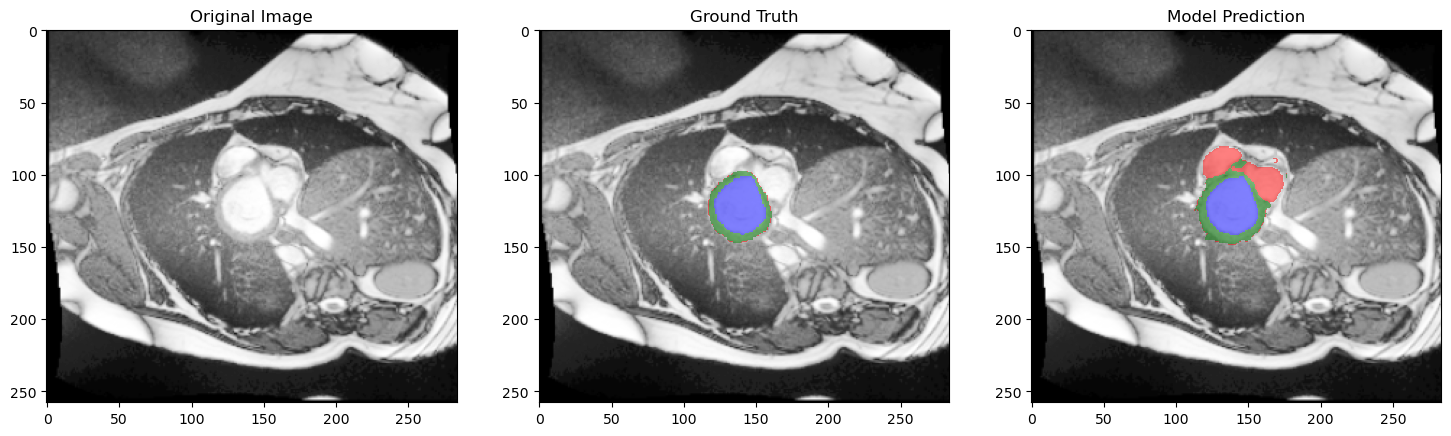

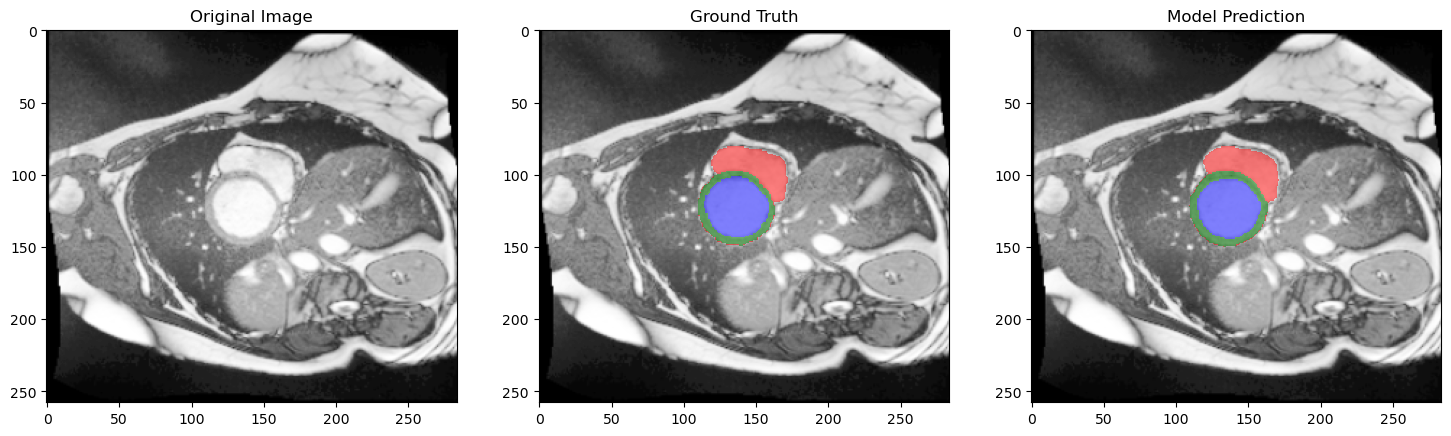

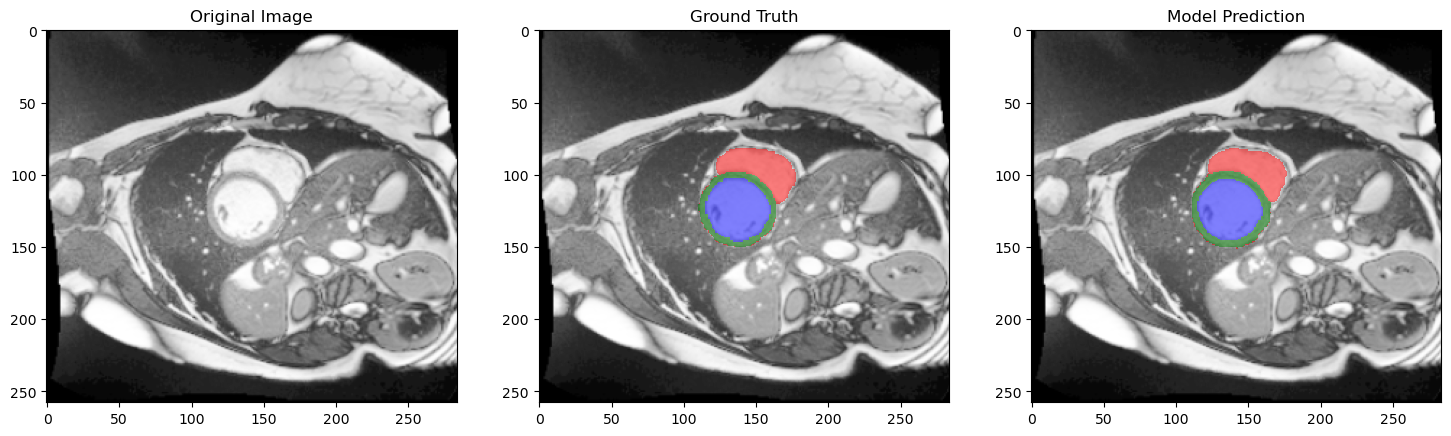

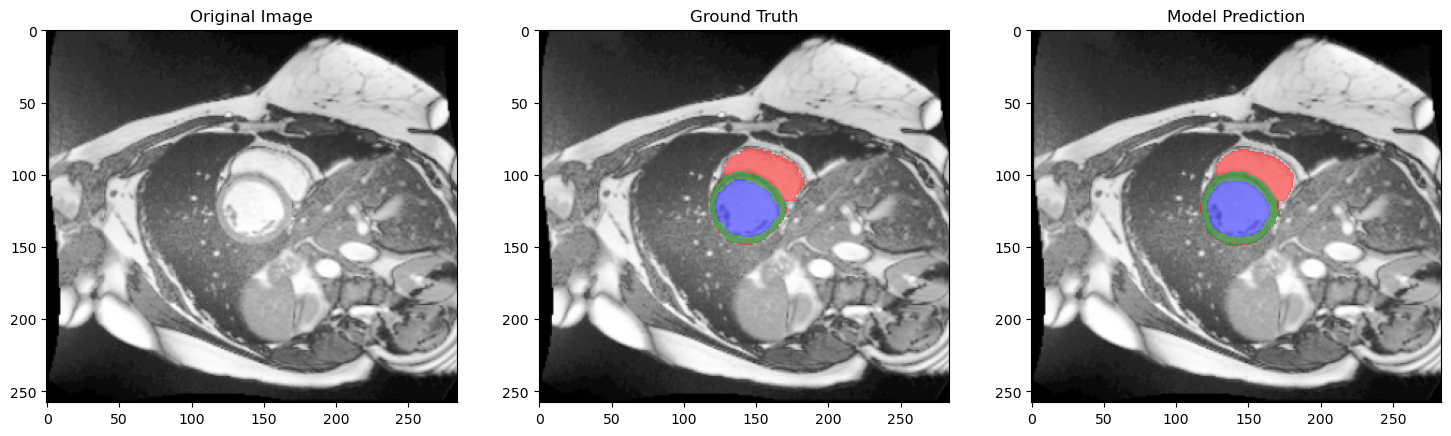

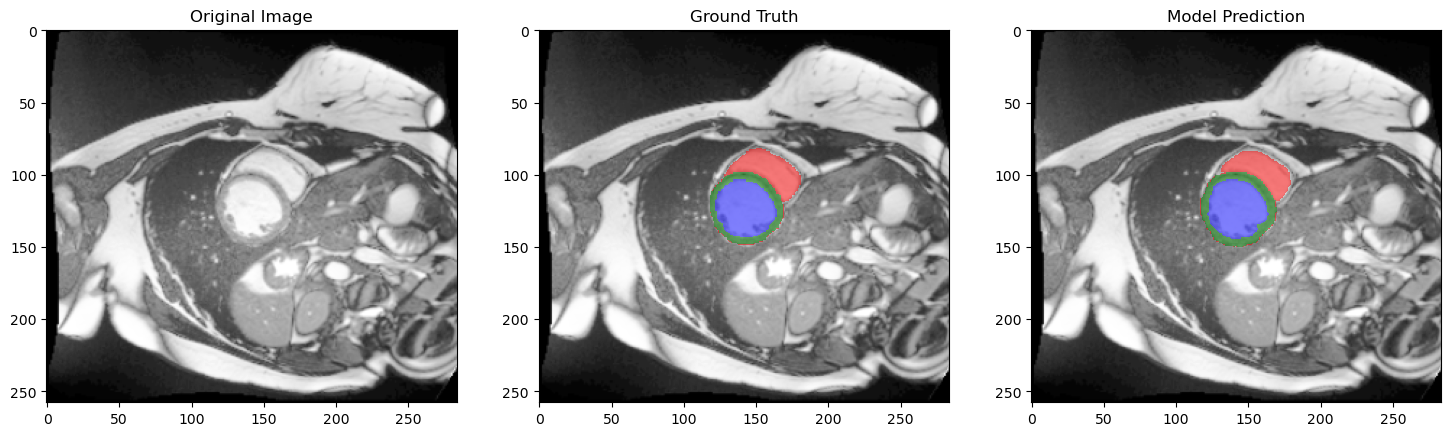

In [15]:
def visual_evaluation(sample, model):
    """
    Allow the visual inspection of one sample by plotting the image, the ground truth,
    and the segmentation map produced by the network.
    
    Args:
        sample (Dict[str, torch.Tensor]): sample composed of an image ('image') and a mask ('label').
        model (torch.nn.Module): trained model to evaluate.
    """
    model.eval()
    inferer = monai.inferers.SlidingWindowInferer(roi_size=[size_x, size_y]) 
    softmax = torch.nn.Softmax(dim=1)

    # Ensure the input is float32
    sample_image = sample['image'].to(device)
    #check if image is float or double
    #print(sample_image.dtype)

    with torch.no_grad():
        output = softmax(inferer(sample_image, network=model)).squeeze()

    # Convert the ground truth and prediction to the format suitable for visualization
    #torch.Size([1, 1, 232, 256])
    #convert to 232, 256
    ground_truth = sample['label'].squeeze().numpy()
    #ground_truth = torch.argmax(sample['label'].squeeze(), dim=0).numpy()
    predicted_label = torch.argmax(output, dim=0).cpu().numpy()

    fig, ax = plt.subplots(1, 3, figsize=[18, 6])

    # Plot original image
    ax[0].imshow(sample['image'].squeeze().numpy(), cmap='gray')
    ax[0].set_title('Original Image')

    # Plot ground truth
    ax[1].imshow(sample['image'].squeeze().numpy(), cmap='gray')
    ax[1].imshow(ground_truth, cmap=label_cmap, alpha=0.5)
    ax[1].set_title('Ground Truth')

    # Plot model prediction
    ax[2].imshow(sample['image'].squeeze().numpy(), cmap='gray')
    ax[2].imshow(predicted_label, cmap=label_cmap, alpha=0.5)
    ax[2].set_title('Model Prediction')

    plt.show()
    
test_transform = monai.transforms.Compose([
    LoadData(keys=['image', 'label']),
    HistogramEqualization(),
    monai.transforms.ScaleIntensityd(keys=['image'], minv=0.0, maxv=1.0),
    monai.transforms.SpacingD(keys=['image', 'label'], pixdim=(pixdim_x, pixdim_y, None), mode=['bilinear', 'nearest']),
    ConvertToFloat32(),
    monai.transforms.ToTensorD(keys=['image', 'label'])
])

test_dataset = Dataset(data=testing_slices_dict, transform=test_transform)
test_loader = DataLoader(test_dataset, batch_size=1)

test_ed_dataset = Dataset(data=testing_ed_slices_dict, transform=test_transform)
test_ed_loader = DataLoader(test_ed_dataset, batch_size=1)

test_es_dataset = Dataset(data=testing_es_slices_dict, transform=test_transform)
test_es_loader = DataLoader(test_es_dataset, batch_size=1)

i = 0
for sample in test_loader:
    visual_evaluation(sample, model)
    i += 1
    if i == 5:
        break


**Evaluation Metrics**

In [16]:
from monai.metrics import DiceMetric, HausdorffDistanceMetric

def compute_metric(dataloader, model, metric_fn, num_classes):

    model.eval()
    inferer = monai.inferers.SlidingWindowInferer(roi_size=[size_x, size_y])
    softmax = torch.nn.Softmax(dim=1)

    metric_values = []

    for sample in tqdm(dataloader, desc="Evaluating"):
        with torch.no_grad():
            output = softmax(inferer(sample['image'].to(device), network=model)).cpu()
            predicted_label = torch.argmax(output, dim=1)  # Shape: (B, H, W)

        # Add batch dimension to match the expected input format
        predicted_label = predicted_label.unsqueeze(1)  # Shape: (B, 1, H, W)
        ground_truth_label = sample["label"]  # Shape: (B, 1, H, W)

        # Ensure the values are in the correct format for multi-class Dice computation
        predicted_label = torch.nn.functional.one_hot(predicted_label.squeeze(1), num_classes=num_classes).permute(0, 3, 1, 2).float()
        ground_truth_label = torch.nn.functional.one_hot(ground_truth_label.squeeze(1).long(), num_classes=num_classes).permute(0, 3, 1, 2).float()

        metric_fn(y_pred=predicted_label, y=ground_truth_label)
        batch_metric_value = metric_fn.aggregate(reduction="none").cpu().numpy()
        metric_values.append(batch_metric_value)
        metric_fn.reset()

        #print(f"Batch Metric: {batch_metric_value}")

    # Calculate mean per class
    metric_values = torch.tensor(metric_values)
    metric_values[torch.isinf(metric_values)] = float('nan')
    mean_metric_per_class = metric_values.nanmean(dim=0).numpy()

    return mean_metric_per_class

In [17]:
dice_metric = DiceMetric(include_background=True, reduction="mean_channel", num_classes=num_classes, ignore_empty=True)
hausdorff_metric = HausdorffDistanceMetric(include_background=True)

#Get metrics for ED and ES
mean_dice_per_class_ed = compute_metric(test_ed_loader, model, dice_metric, num_classes)
mean_dice_per_class_es = compute_metric(test_es_loader, model, dice_metric, num_classes)
hausdorff_values_ed = compute_metric(test_ed_loader, model, hausdorff_metric, num_classes)
hausdorff_values_es = compute_metric(test_es_loader, model, hausdorff_metric, num_classes)

Evaluating: 100%|██████████| 538/538 [00:28<00:00, 18.63it/s]
C:\Users\gijsd\AppData\Local\Temp\ipykernel_9288\3240808576.py:32: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\cb\pytorch_1000000000000\work\torch\csrc\utils\tensor_new.cpp:277.)
  metric_values = torch.tensor(metric_values)
Evaluating:   0%|          | 0/538 [00:00<?, ?it/s]C:\Users\gijsd\anaconda3\Lib\site-packages\monai\metrics\utils.py:333: UserWarning: the ground truth of class 1 is all 0, this may result in nan/inf distance.
  warnings.warn(
Evaluating:   3%|▎         | 16/538 [00:01<00:41, 12.50it/s]C:\Users\gijsd\anaconda3\Lib\site-packages\monai\metrics\utils.py:333: UserWarning: the ground truth of class 2 is all 0, this may result in nan/inf distance.
  warnings.warn(
C:\Users\gijsd\anaconda3\Lib\site-packages\monai\metrics\utils.py:333: Use

In [19]:
# Create a DataFrame to store the evaluation results
results = pd.DataFrame({'Class': class_names, 'Mean Dice ED': mean_dice_per_class_ed[0], 'Mean Dice ES': mean_dice_per_class_es[0], 'Hausdorff ED': hausdorff_values_ed[0], 'Hausdorff ES': hausdorff_values_es[0]})
results = results[results['Class'] != 'background'] # Remove the background class, since the leaderboard does not include it

#save results to csv
results.to_csv('results_' + run_name + '.csv', index=False, decimal=',', sep=';')
results

,Class,Mean Dice ED,Mean Dice ES,Hausdorff ED,Hausdorff ES
1,RV,0.878404,0.818090,11.611998,12.551798
2,MY,0.824716,0.857989,5.756614,5.939086
3,LV,0.921028,0.882133,3.903536,3.906736
